In [1]:
from jedi import jedi
from jedi.utils import plot, seedutil, func_generator, init_tools

from functools import partial
import random
import types
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from __future__ import division
from scipy.integrate import odeint, ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace, \
    cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice
import numpy.linalg as la
from scipy.optimize import minimize

from ipywidgets import interact, fixed
from sklearn.decomposition import PCA

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [3]:
# Setting Seeds
seeds = random.sample(range(100000), 1)

$$ \frac{dx}{dt} = -x + J_r r(x) + J_u u + J_z z$$

# Test Signals

## 1) Sin Wave

In [4]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [5]:
# sine-wave target
target = lambda t0: cos(2 * pi * t0/.5)

In [6]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 6  # simulation length
tstart = 2 # learning start time
tstop = 4  # learning stop time
rho = 1.5   # spectral radius of J
N = 300      # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.1,1,1) # sparsity

In [7]:
errors = []

for seedling in seeds:
    J, Wz, _, x0, u, w = init_tools.set_simulation_parameters(seedling, N, 1, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, params):
        tanh_x = params['tanh_x']
        z = params['z']
        return (-x + dot(J, tanh_x) + Wz*z)/dt 

    x, t, z, _, wu,_ = jedi.force(target, model, lr, dt, tmax, tstart, tstop, x0, w, 0)

    error = np.abs(z-target(t))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 2.979 seconds


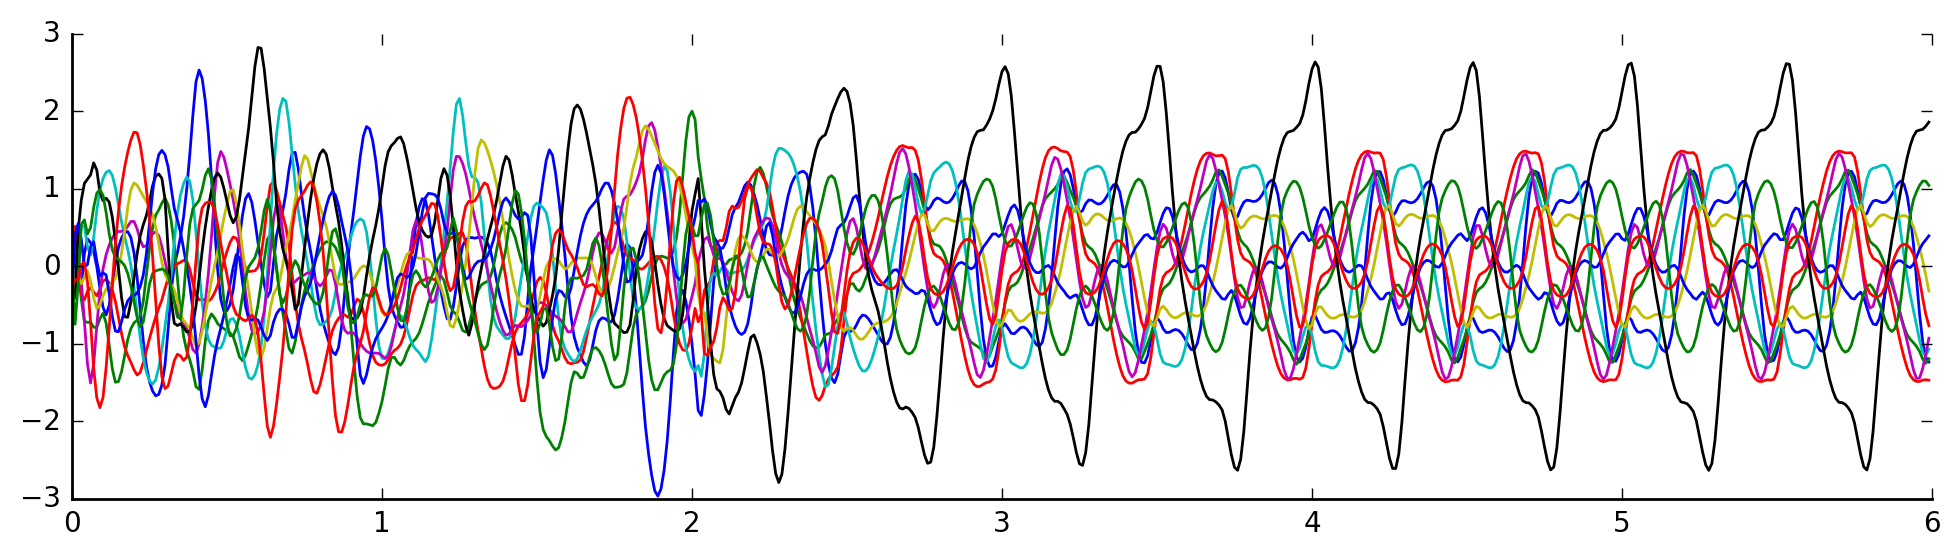

In [8]:
# Visualizing activities of first 20 neurons
T = 600

plt.figure(figsize=(12,3))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in range(10):
    ax.plot(t[:T], x[:T, i])


In [9]:
plt.vlines?

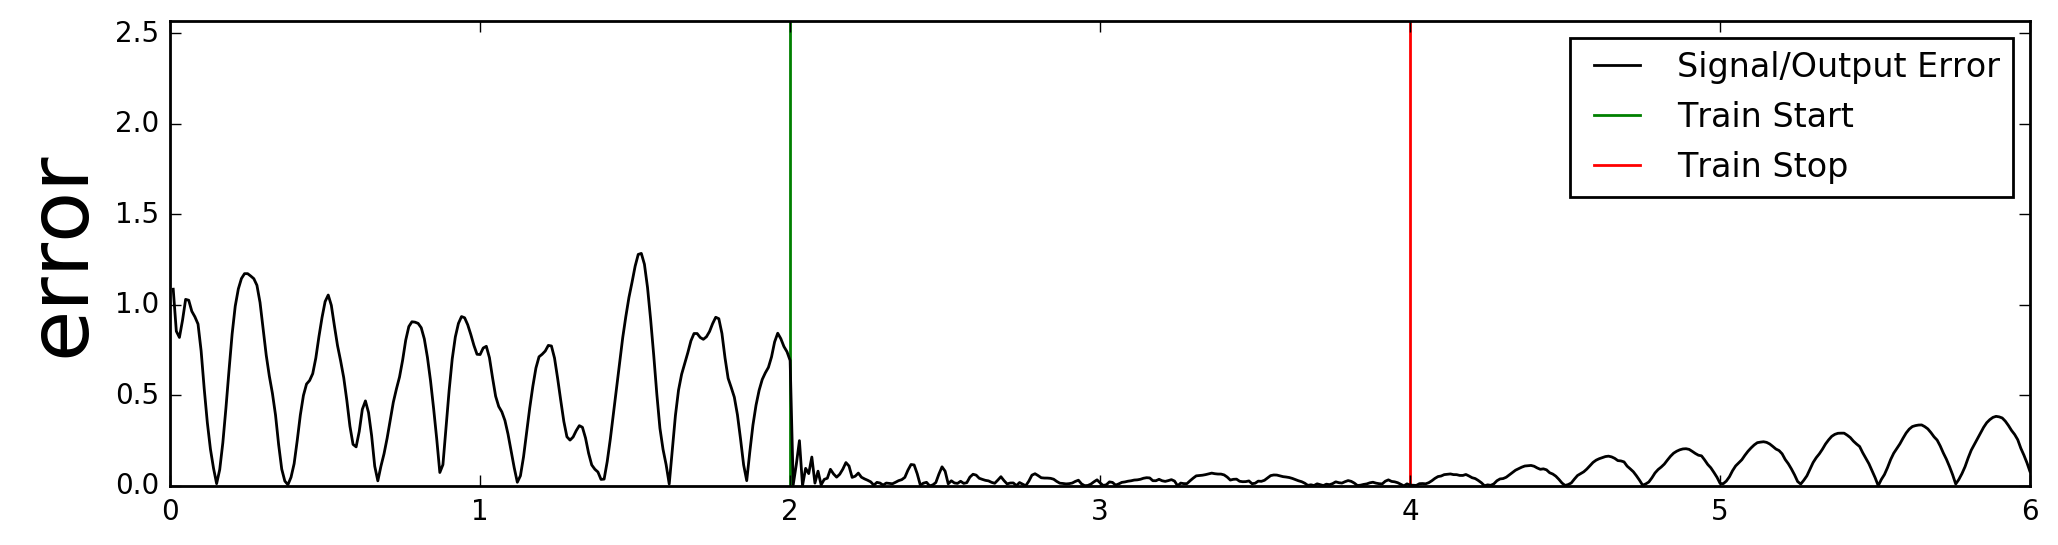

In [10]:
errs = errors
burn_in = 1
title = ""

plt.figure(figsize=(12,3))
plt.xlim(0,6)
mean = True
if mean:
    errs = np.mean(errs, axis=0)
ymax = 2*np.max(errs[burn_in:])
plt.plot(t[burn_in:], errs[burn_in:], 'k', label="Signal/Output Error")
plt.vlines(tstart,0, ymax, colors='g', label='Train Start')
plt.vlines(tstop,0, ymax, colors='r', label='Train Stop')
plt.ylim(0,ymax)
#plt.xlabel('time', fontweight='bold', fontsize=16)
plt.ylabel('error', fontsize=30)
plt.title(title, fontweight='bold', fontsize=20)
plt.legend();

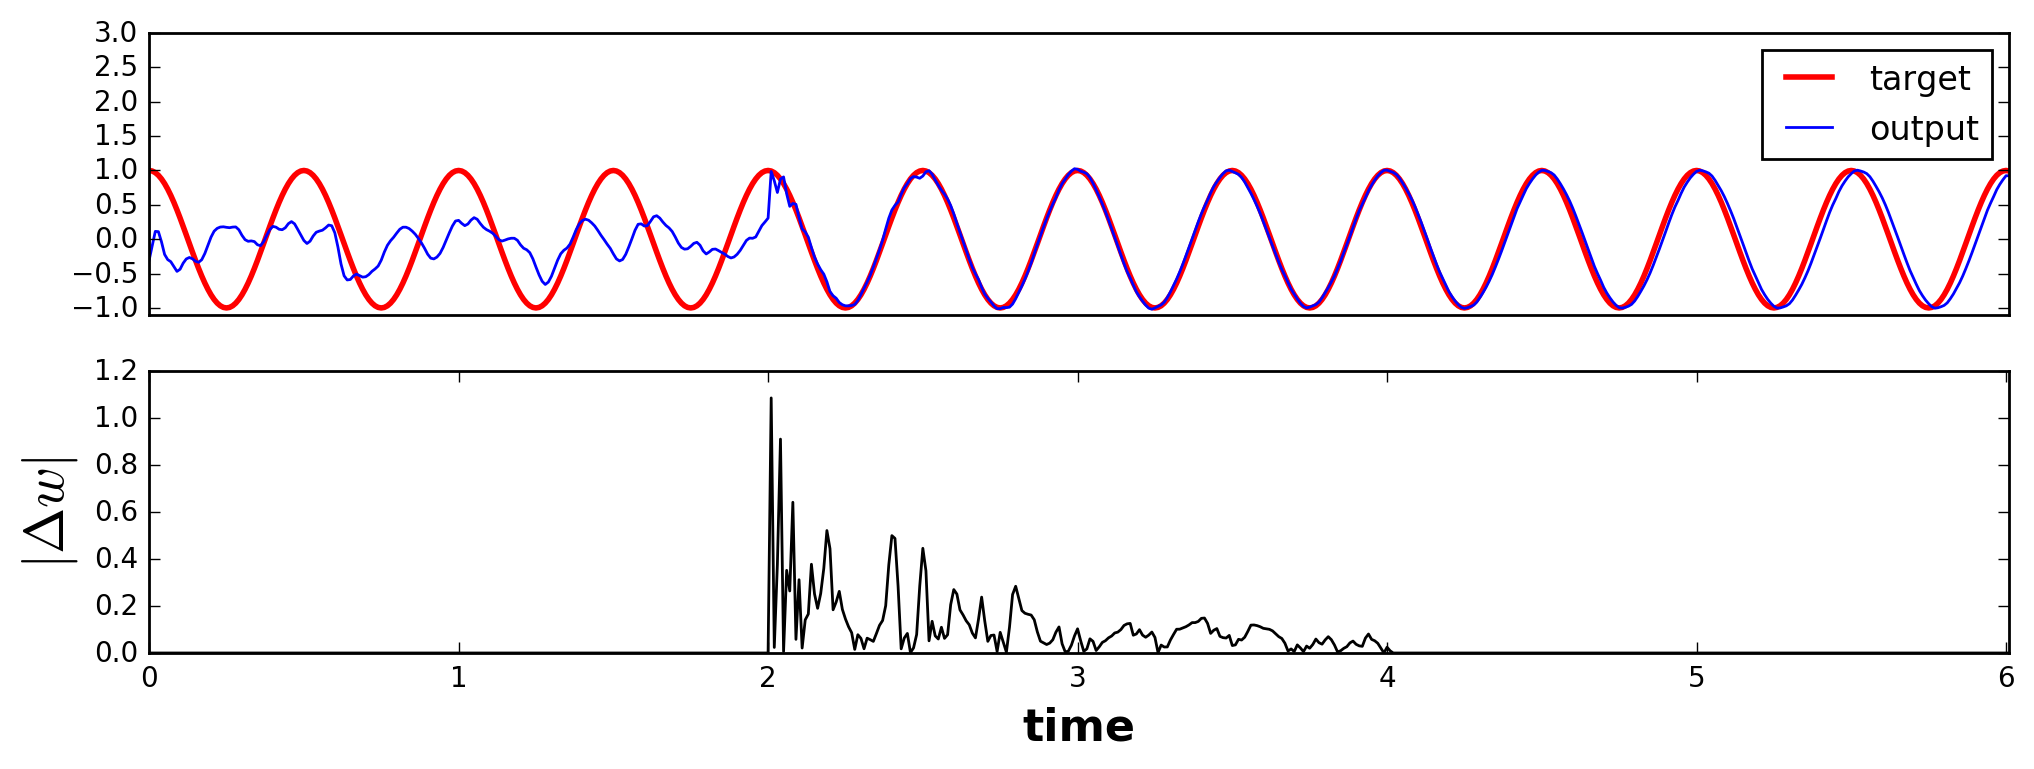

In [11]:
plt.figure(figsize=(12,4))
plot.target_vs_output_plus_error(t, z, wu, target, offset=1, log=False)

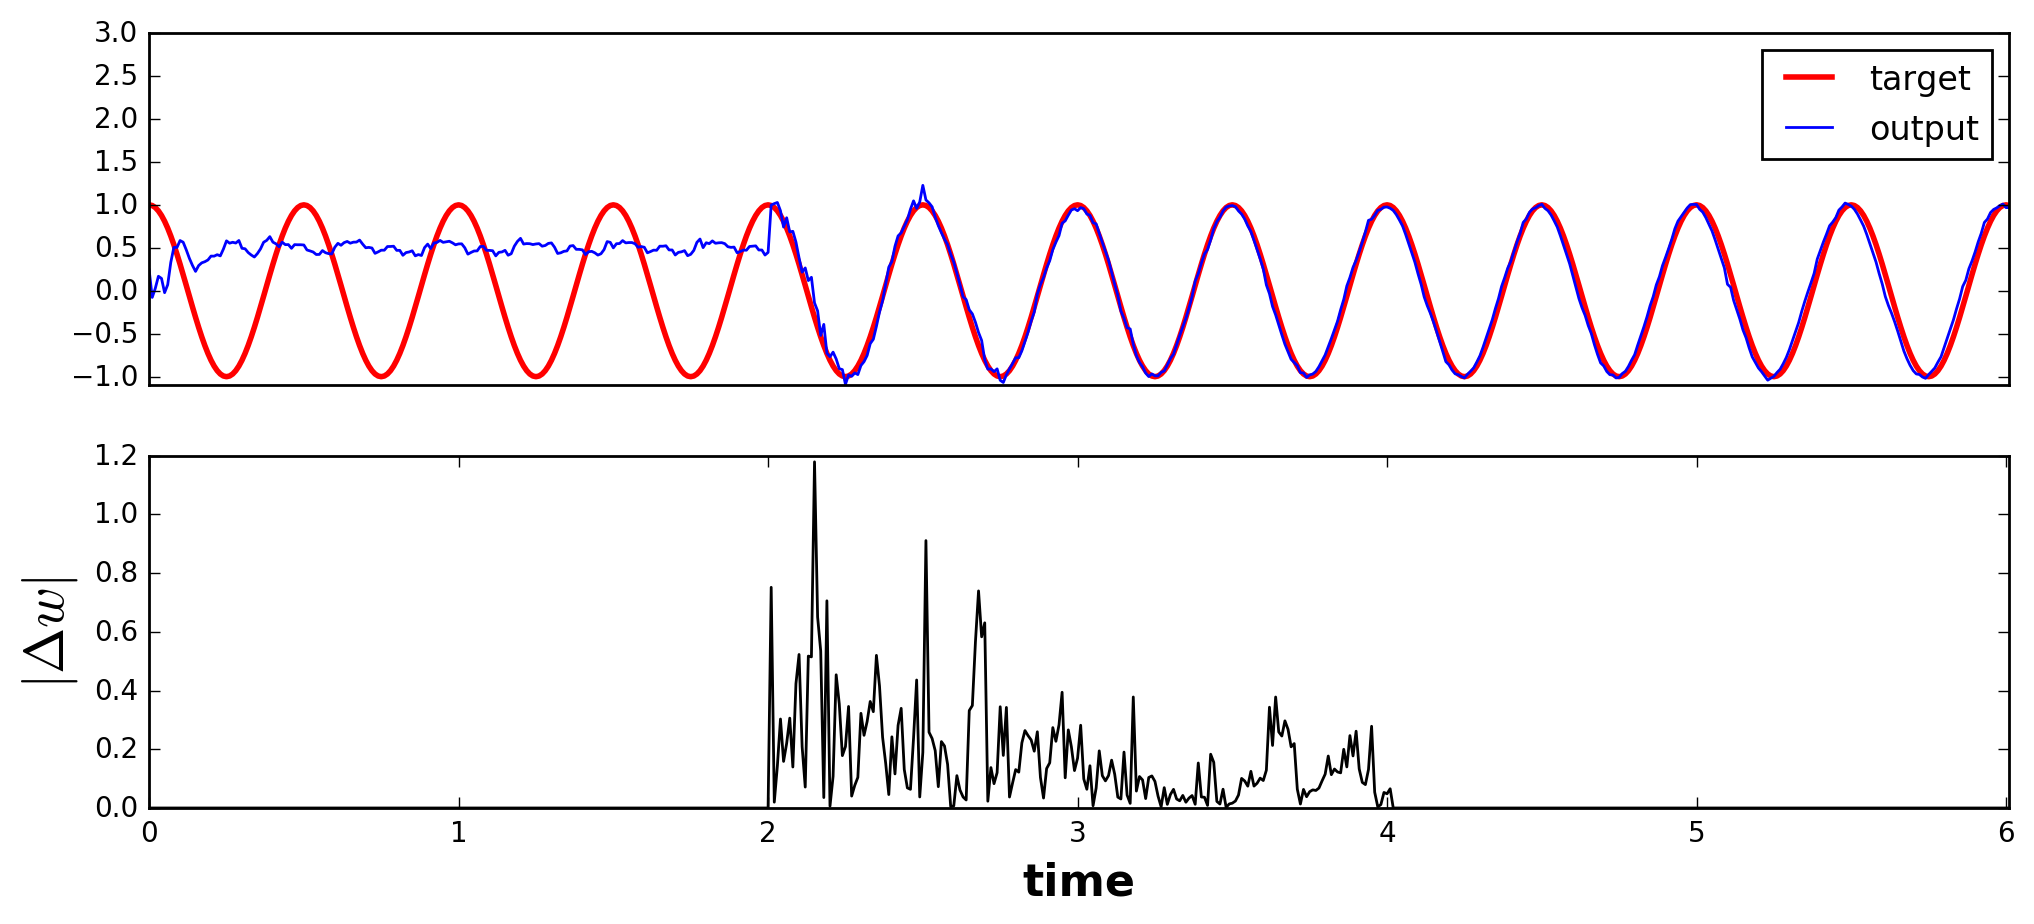

In [33]:
plt.figure(figsize=(12,5))
plot.signal_error(derrors, t, tstart, tstop, title="DFORCE (Sin Wave)", burn_in=5)
plot.target_vs_output_plus_error(t, z, wu, target, log=False)

## 2) 1D Flip-Flop

In [12]:
reload(func_generator)

<module 'jedi.utils.func_generator' from '/Users/simonhaxby/Code/Python/jedi/utils/func_generator.pyc'>

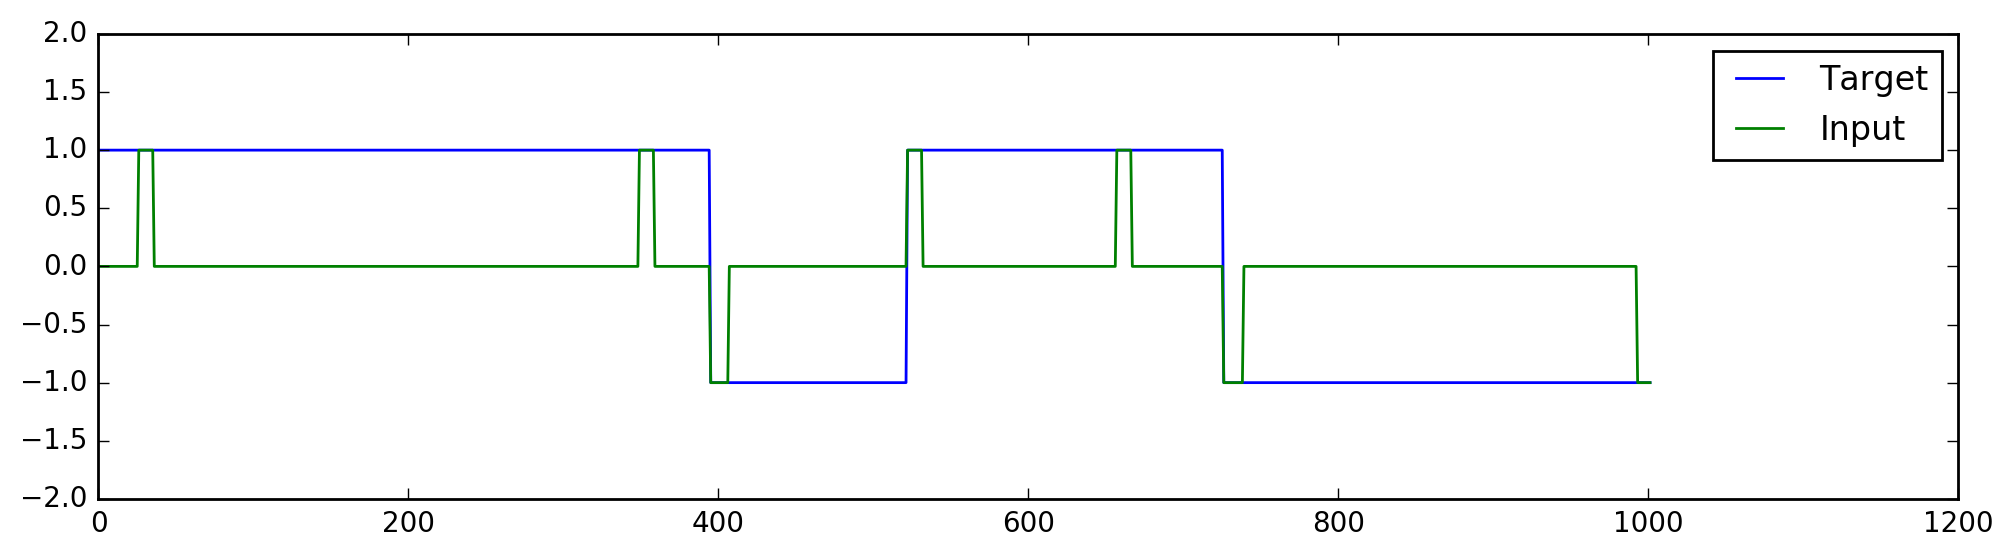

In [13]:
# Plotting inputs and targets
tmax = 10
dt = .01
n = 1

inputs, targets = func_generator.flip_flop_generator(n=n, spikes=[[5,5] for _ in range(n)], t=tmax, dt=dt)
scale = 3
plt.figure(figsize=(12, scale*n))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(range(int(tmax/dt)+2), targets[i], label="Target");
    plt.plot(range(int(tmax/dt)+2), inputs[i], label="Input");
    plt.ylim(-2,2);
    plt.legend();

In [7]:
targets = np.load("../data/stability/flipflop/targets_tmax10sec.npy")
inputs = np.load("../data/stability/flipflop/inputs_tmax10sec.npy")

In [8]:
t = np.linspace(0,10,1002)

In [9]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstart = 0
tstop = 5  # learning stop time
rho = 1.02  # spectral radius of J
N = 300      # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.05,1,1) # sparsity
I = 1 # input size

In [10]:
errors = []
wus = []
zs = []

for seedling in seeds:
    J, Wz, Wi, x0, u, w = init_tools.set_simulation_parameters(seedling, N, I, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, params):
        index = params['index']
        tanh_x = params['tanh_x']
        z = params['z']
        inp = params['inputs'][index]
        return (-x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z)/dt
    
    x,t,z,w_learn,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstart, tstop, x0, w, inputs=inputs)

    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 2.739 seconds


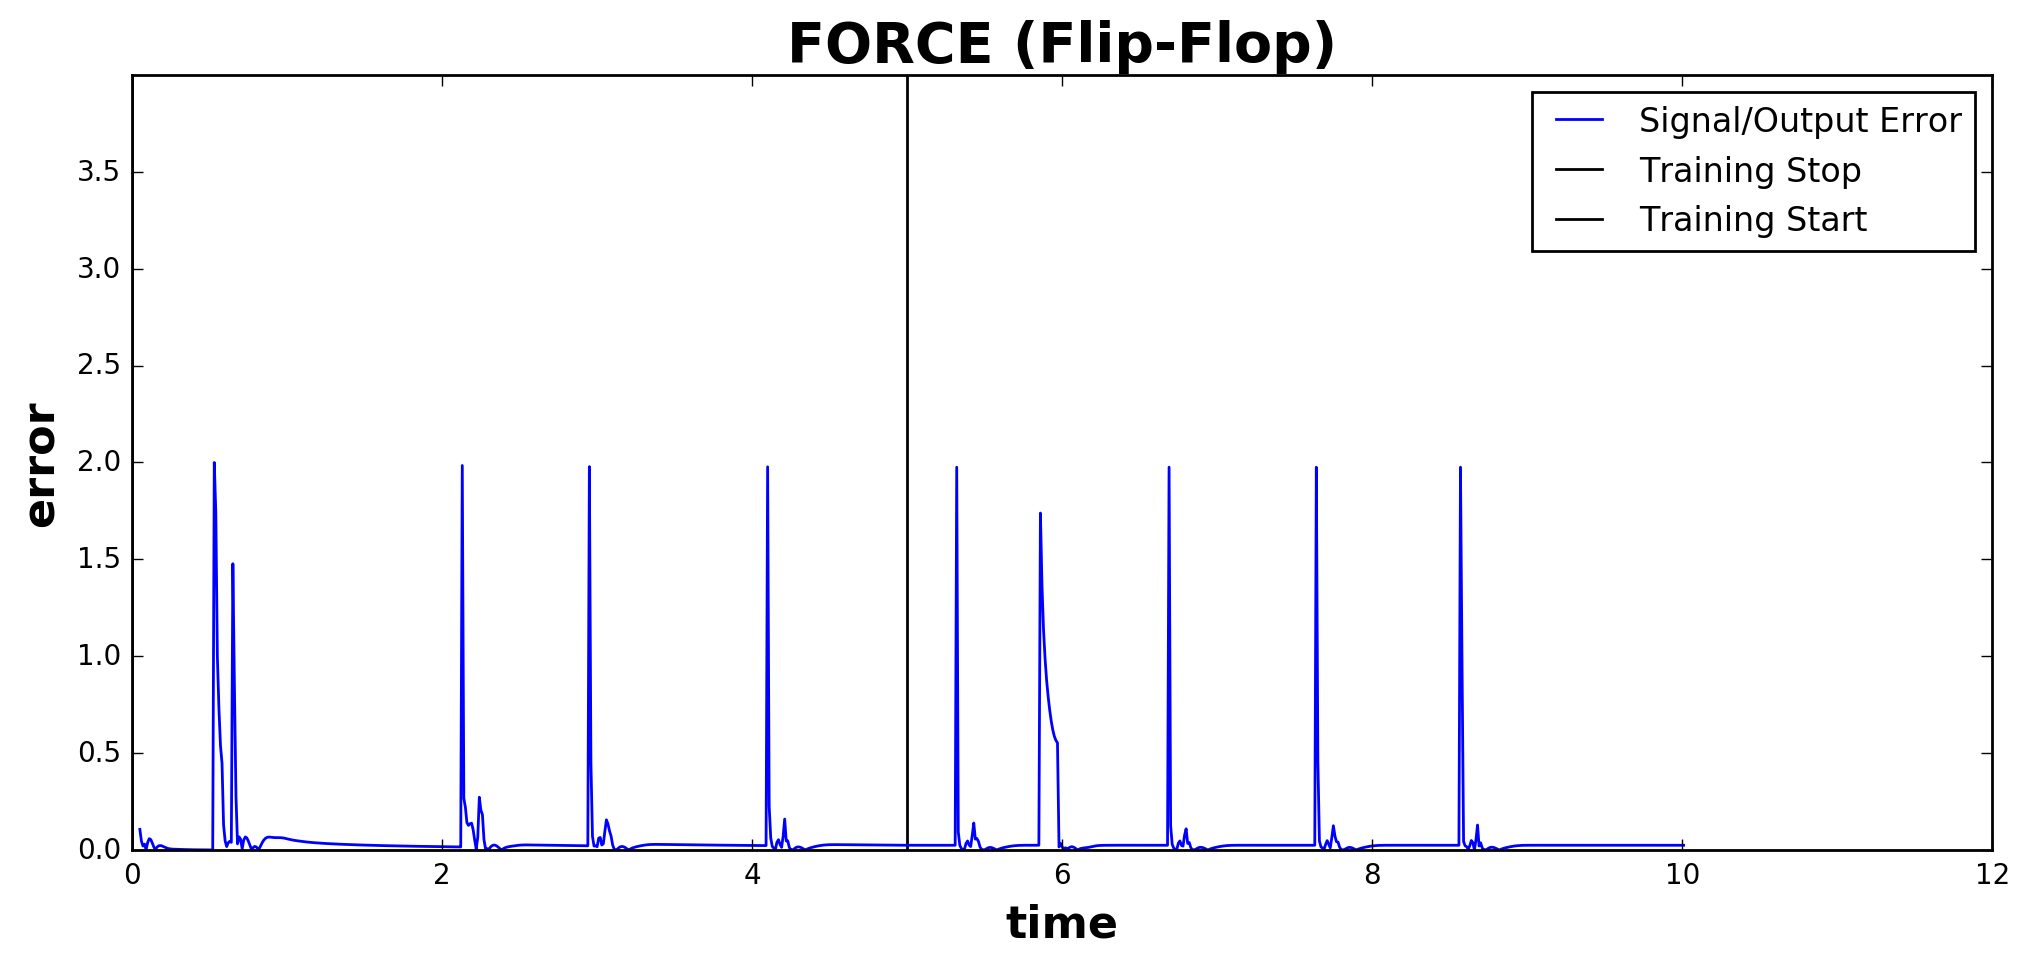

In [11]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t, tstart, tstop, title= "FORCE (Flip-Flop)", burn_in=5)

In [12]:
ind = 0

Seed: 0


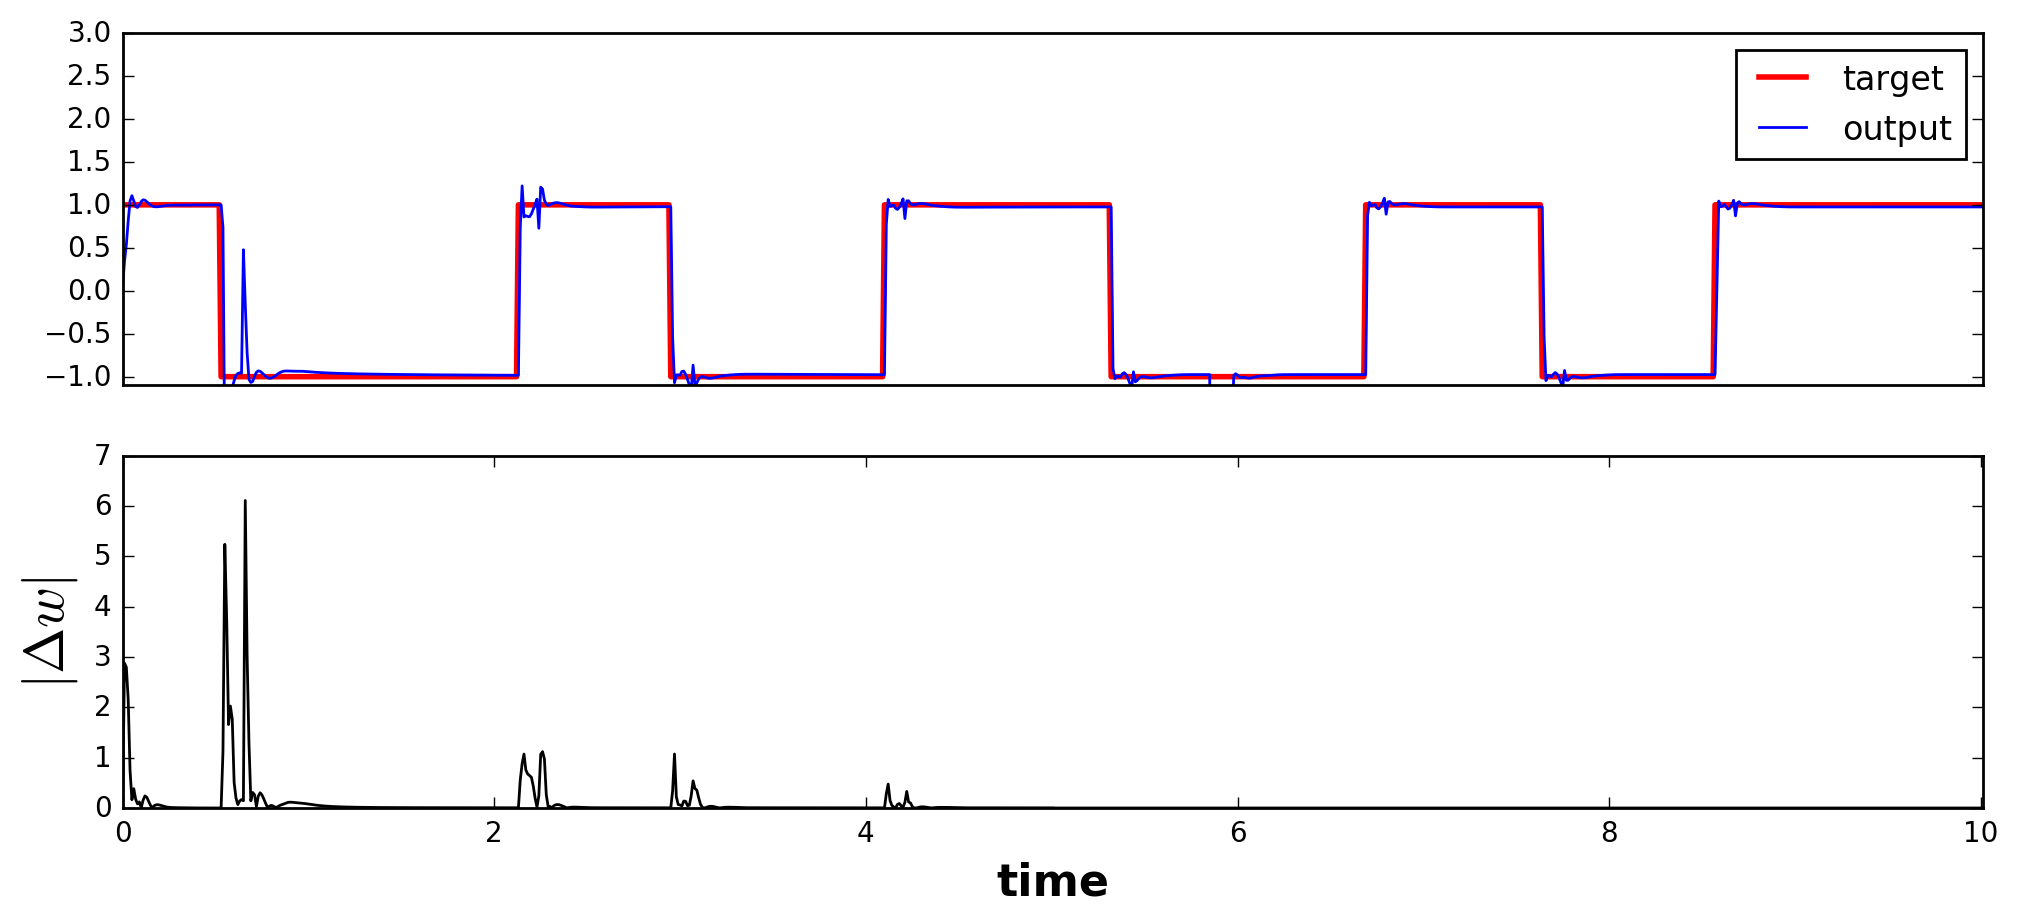

In [13]:
plt.figure(figsize=(12,5))
if ind < len(seeds):
    print("Seed: %d" % ind)
    plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=0, log=False)
    ind+=1

/Users/simonhaxby/anaconda/envs/progress/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


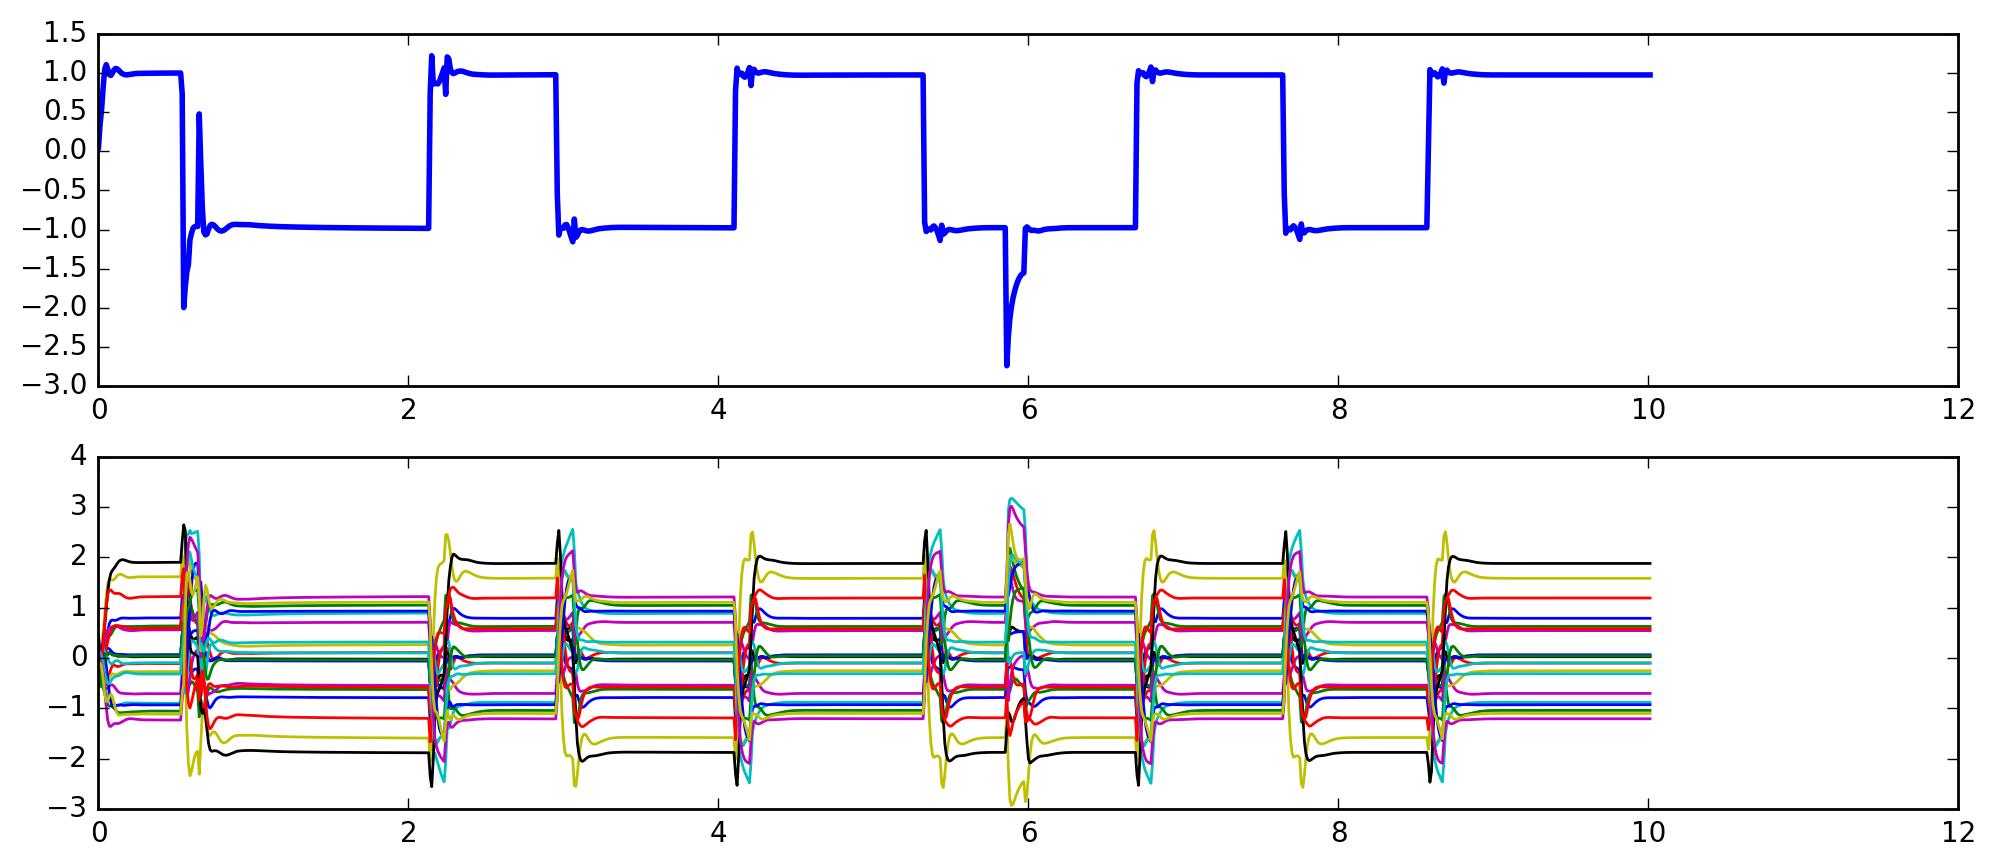

In [14]:
plt.figure(figsize=(12,5))
plt.legend()
plt.subplot(2,1,2)
for i in range(20):
    plt.plot(t[:], x[:, i]);
plt.subplot(2,1,1)
plt.plot(t, np.array(z), lw=2, label="output");

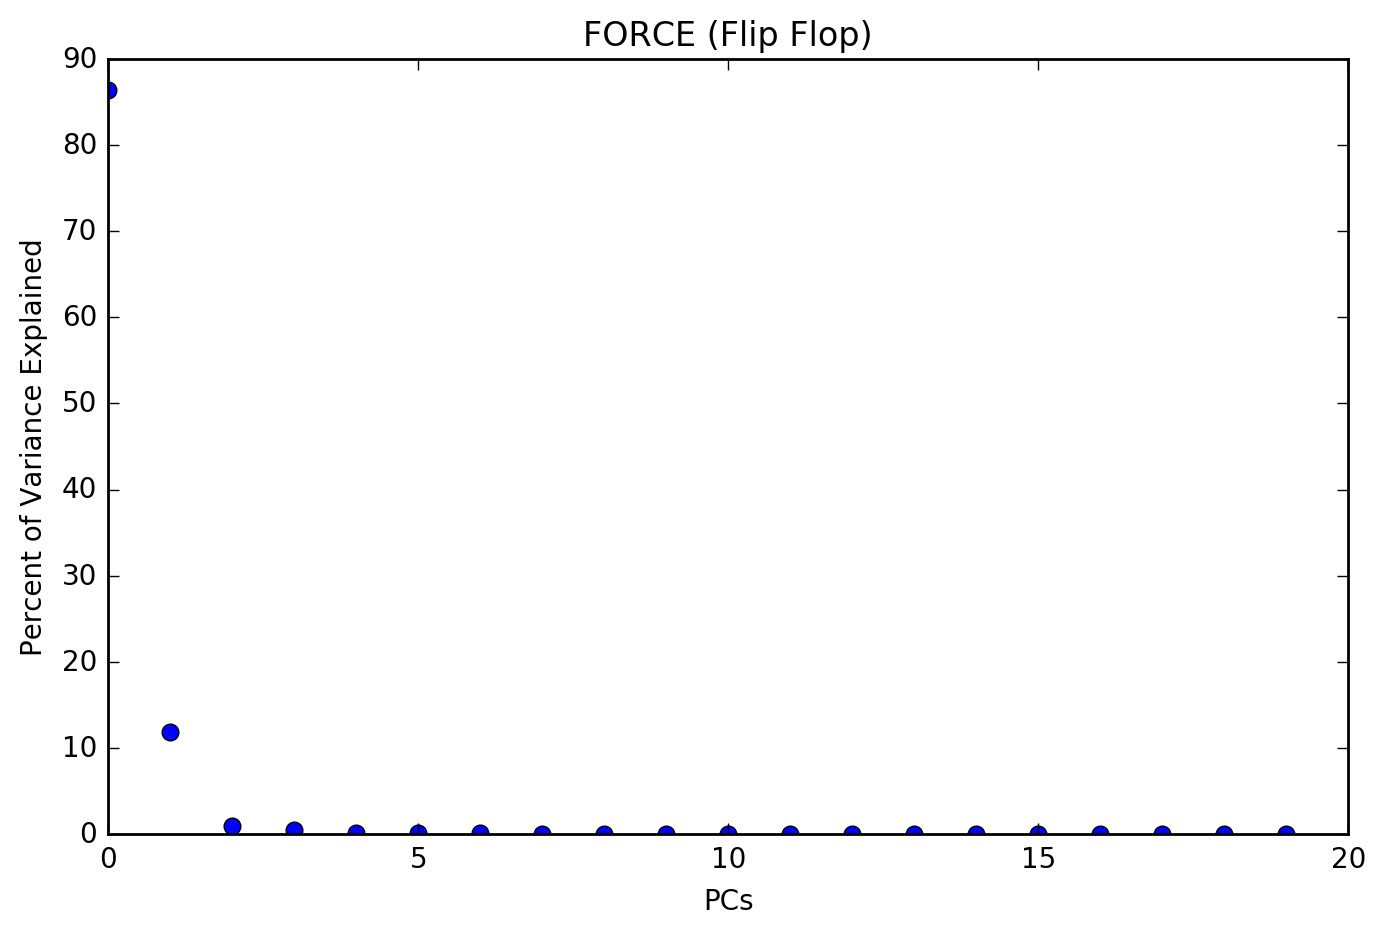

In [15]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [16]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

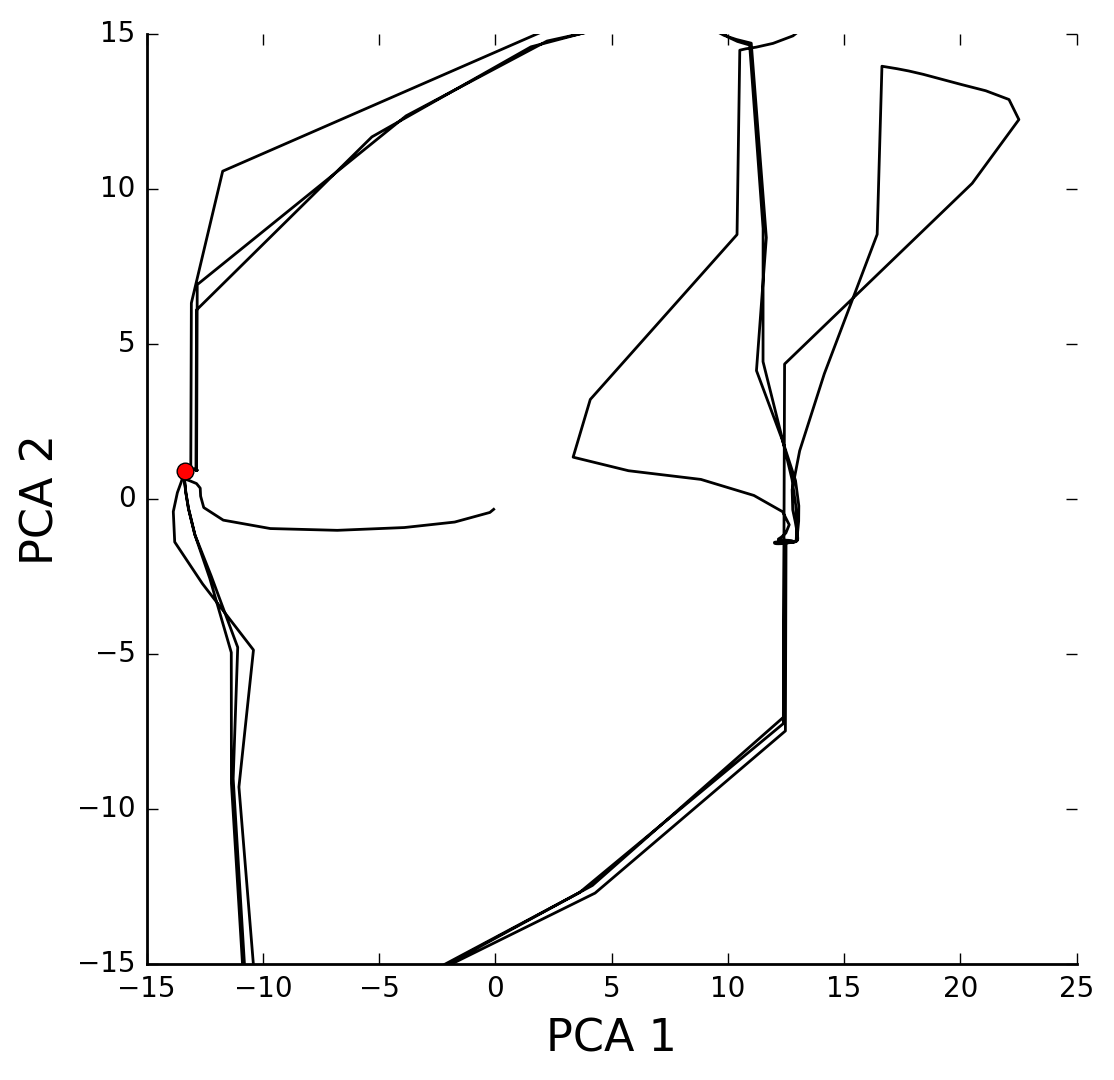

In [17]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

### Fixed Point Analyses

In [18]:
def q(x):
    F = lambda x: -x + dot(J, np.tanh(x)) + Wz*dot(w,np.tanh(x))/dt
    return .5*(la.norm(F(x))**2)

In [19]:
ics = x[np.random.randint(0,1000,10)]

In [20]:
minima = []
for ic in ics:
    minima.append(minimize(q, ic).x)

In [21]:
pca_minima = pca.transform(np.array(minima)).T
pca_ics = pca.transform(np.array(ics)).T

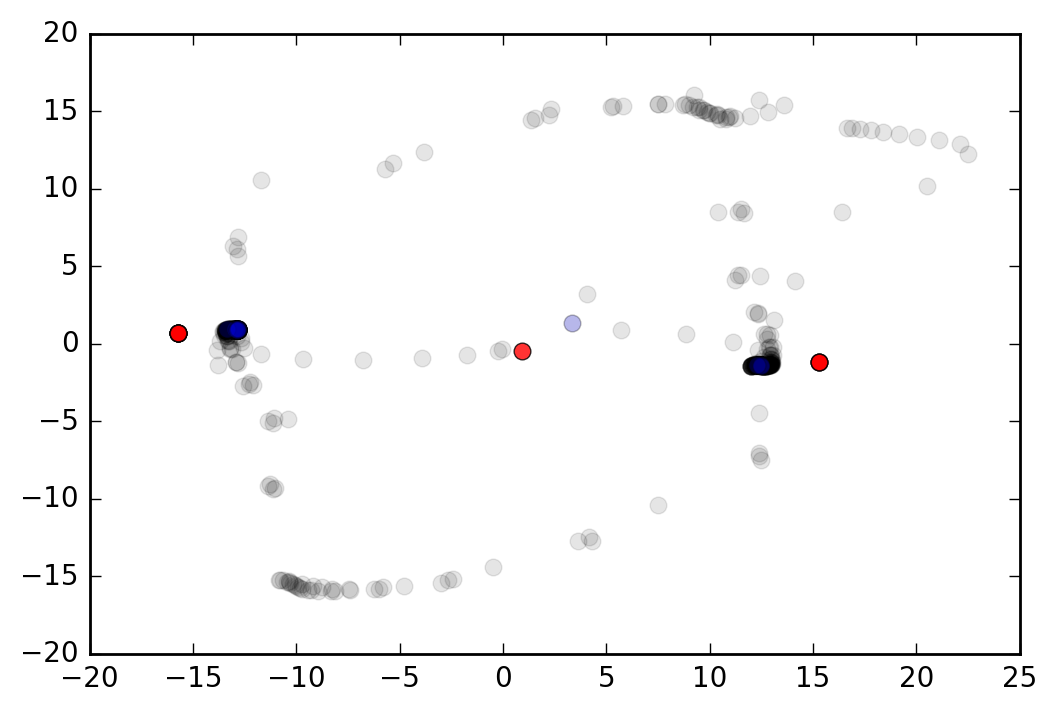

In [22]:
plt.plot(pca_x[0], pca_x[1], 'ko', alpha=.1);
plt.plot(pca_minima[0], pca_minima[1], 'ro', alpha=.8);
plt.plot(pca_ics[0], pca_ics[1], 'bo', alpha=.2);

In [53]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 5  # learning stop time
rho = 1.02   # spectral radius of J
N = 300      # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.1,1,1) # sparsity
I = 1 # input size

## 3) Lorentz Attractor

In [23]:
# Parameters specified by Abbott 2009.
def lorentz((x, y, z), t0, sigma=10., beta=8./3, rho=28.0):
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [24]:
break_in = 500
T = 1501 # period
x0 = np.random.randn(3) # starting vector
t_= np.linspace(0, 60, T)
lorenz = odeint(lorentz, x0, t_)/20
targets = lorenz[break_in:,0]
t_in = t_[break_in:]

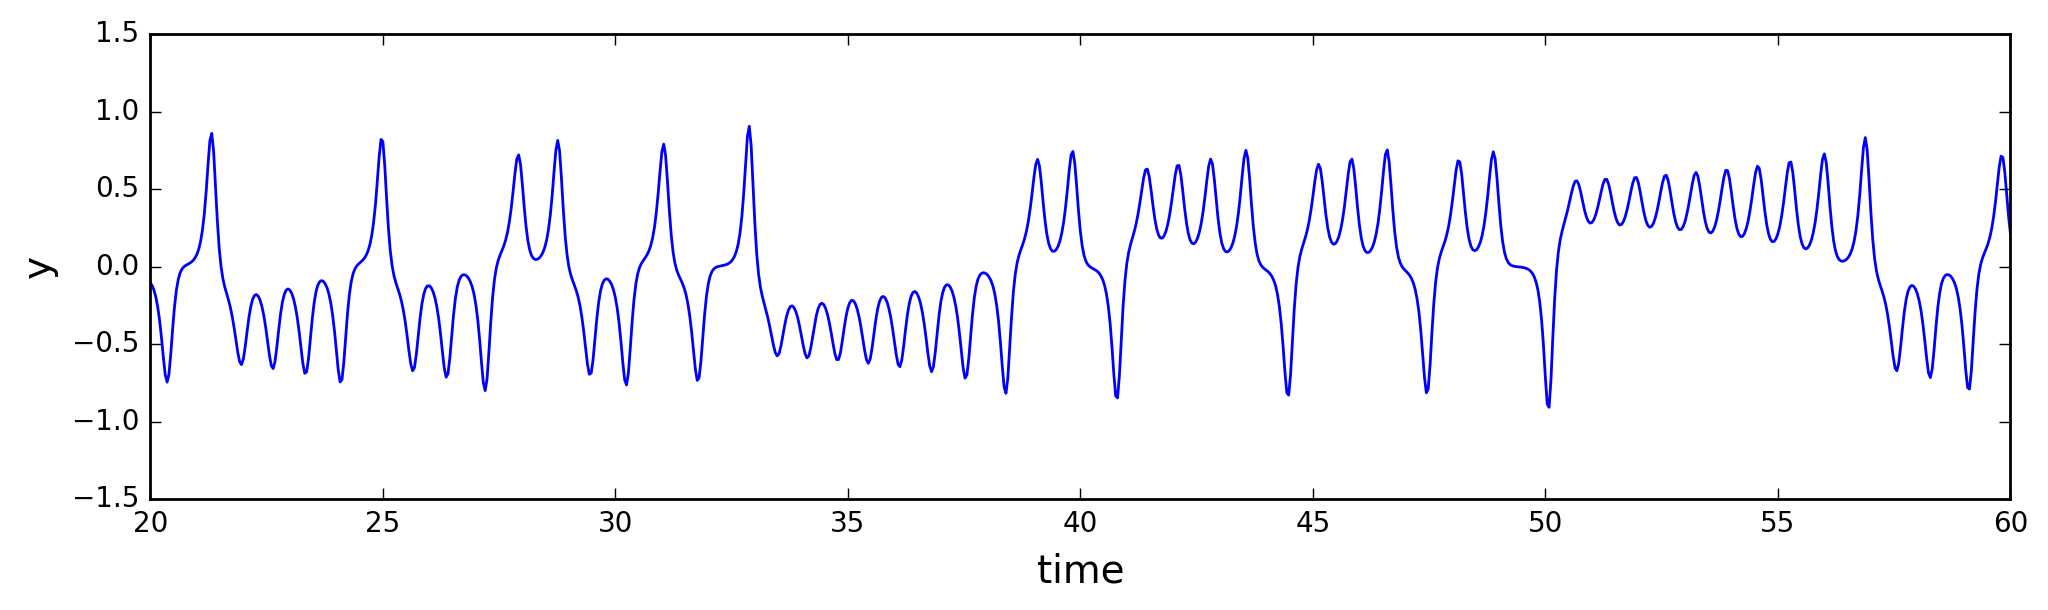

In [25]:
# Visualizing Lorentz attractor
plt.figure(figsize=(12,3))
plt.plot(t_in, targets);
plt.xlim([min(t_in), max(t_in)])
plt.ylim([-1.5,1.5])
plt.xlabel('time', fontsize=14);
plt.ylabel('y', fontsize=14);

In [41]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 8  # learning stop time
rho = 1.2   # spectral radius of J
N = 1000     # size of stochastic pool
lr = 1.0   # learning rate
pE = None # percent excitatory
sparsity = (1,1,1) # sparsity

In [42]:
errors = []
wus = []
zs = []

for seedling in seeds:
    J, Wz, Wi, x0, u, w = init_tools.set_simulation_parameters(seedling, N, I, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, params):
        index = params['index']
        tanh_x = params['tanh_x']
        z = params['z']
        inp = params['inputs'][index]
        return (-x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z)/dt
    
    x,t,z,w_learn,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstart, tstop, x0, w, inputs=inputs)

    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 92.528 seconds


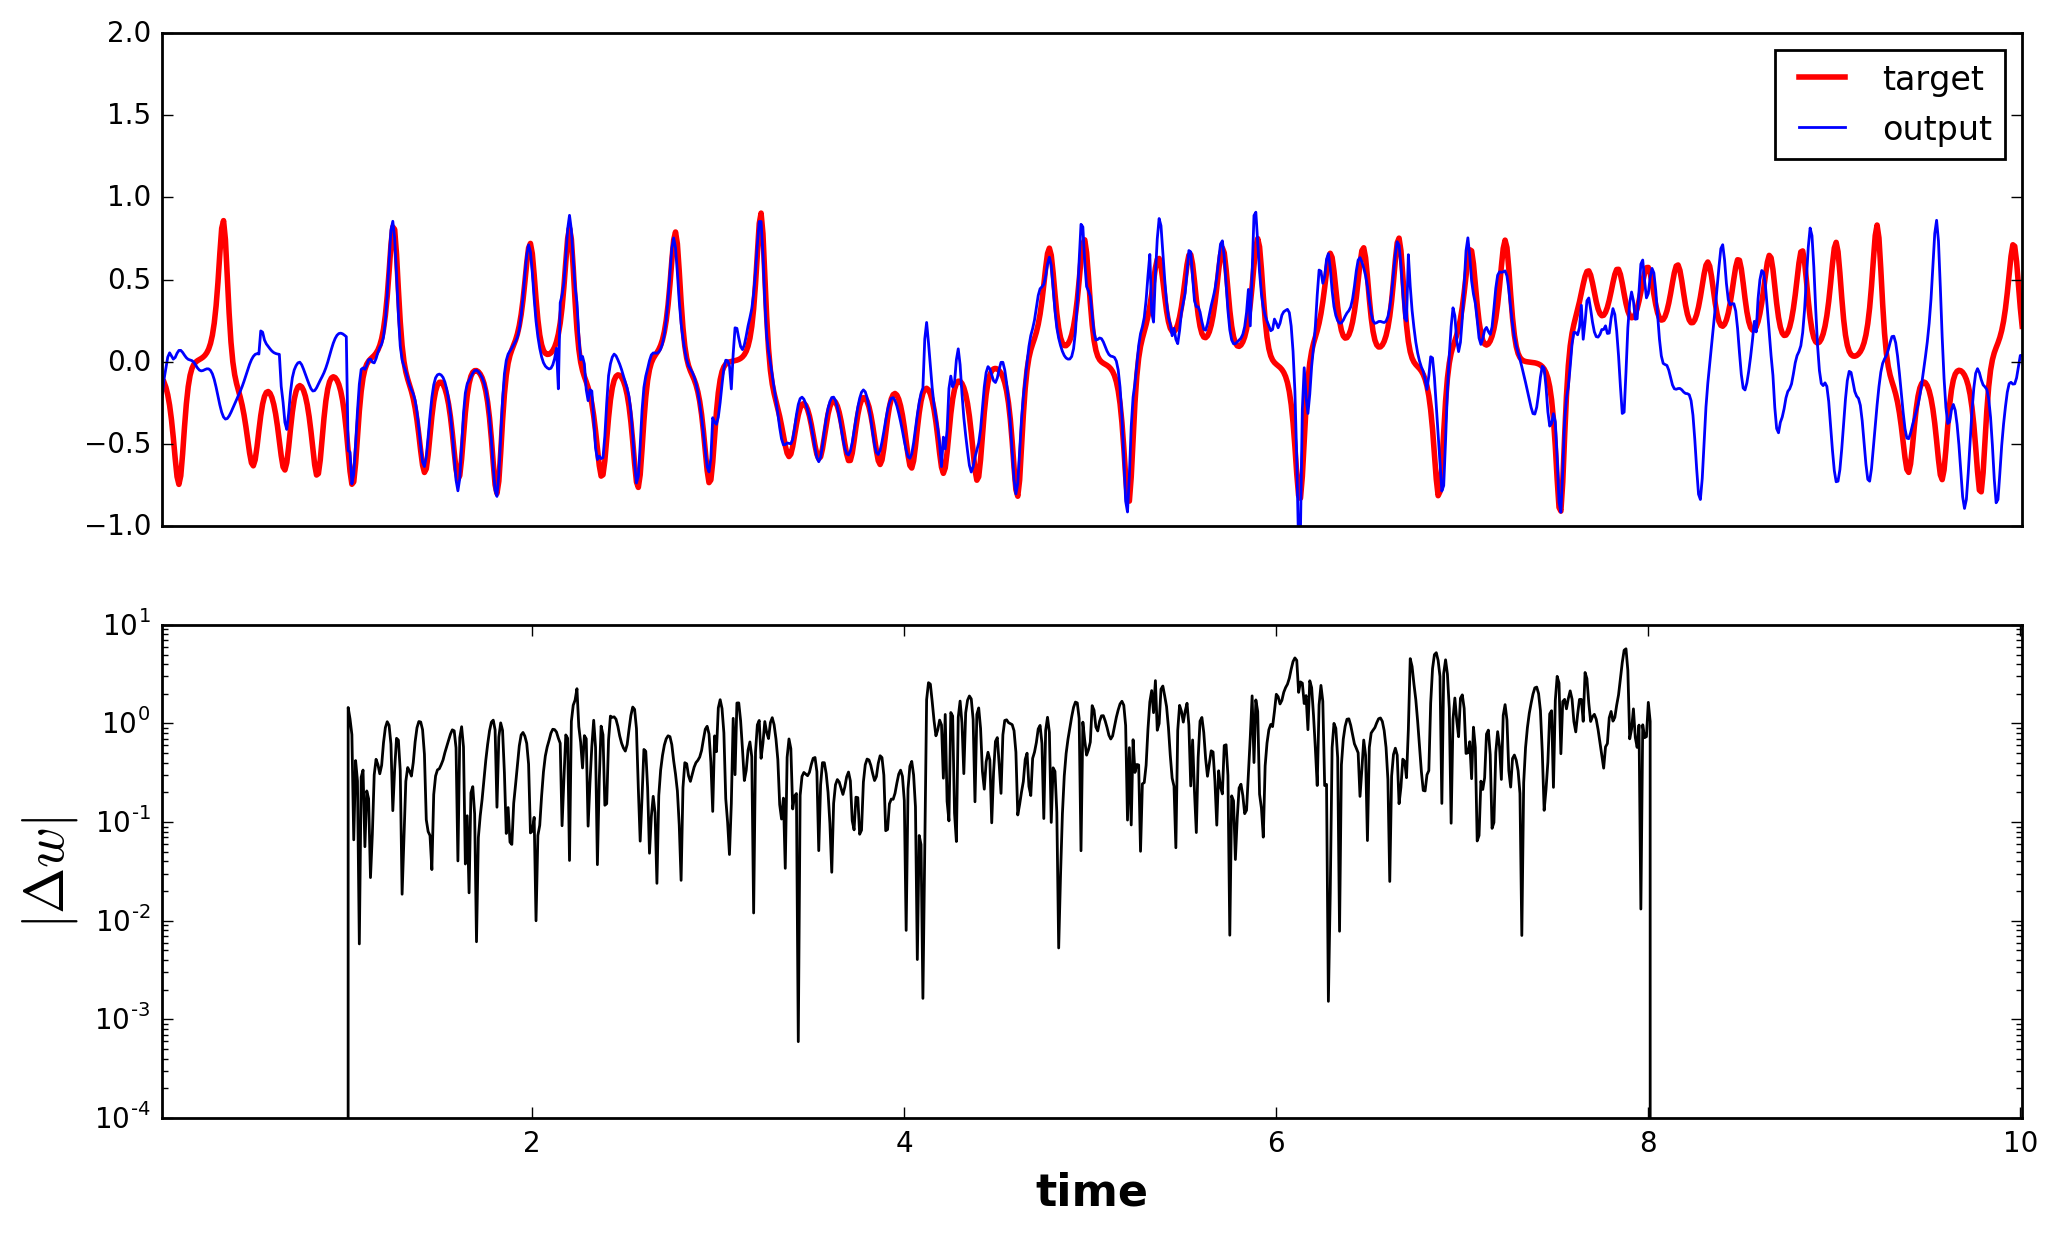

In [43]:
plt.figure(figsize=(12,7))
ind = 0  
tstart = 1
plot.target_vs_output_plus_error(t[tstart:], zs[ind][tstart:], 
                                 wus[ind][tstart:], targets[tstart:], offset=1, ylim=[-1,2])

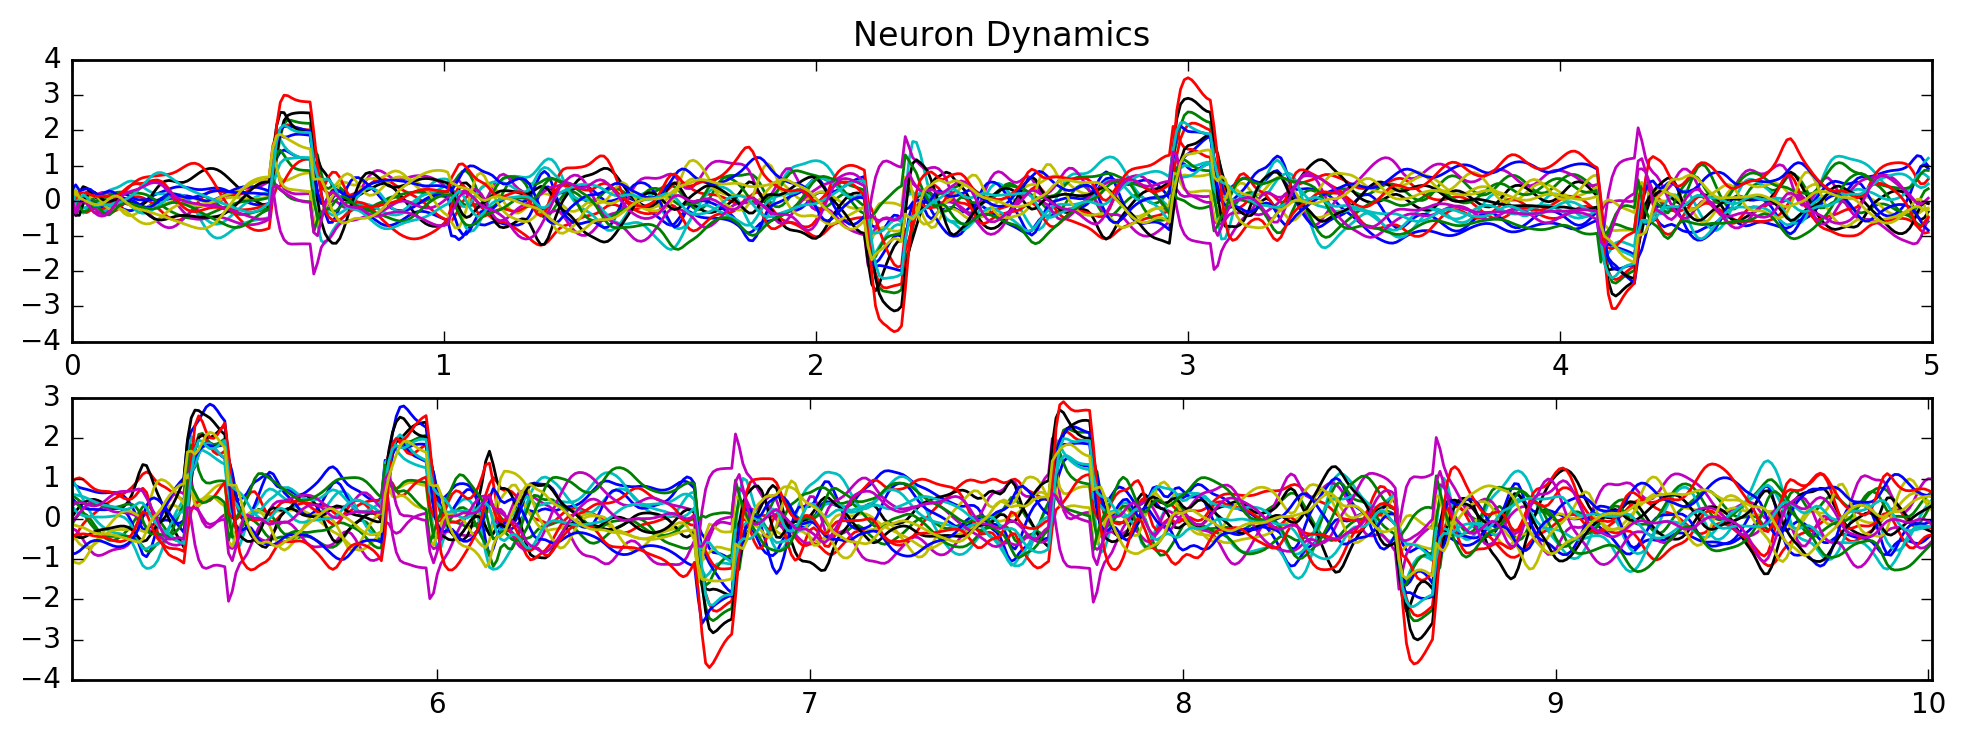

In [44]:
# Visualizing activities of first 20 neurons
T = 500
K = 20

plt.figure(figsize=(12,4))
plt.subplot(211)
plt.title("Neuron Dynamics");
for i in range(K):
    plt.plot(t[:T], x[:T, i]);
    
plt.subplot(212)
for i in range(K):
    plt.plot(t[-T:], x[-T:, i]);
    plt.xlim(t[-T], t[-1])

In [45]:
ind = 0

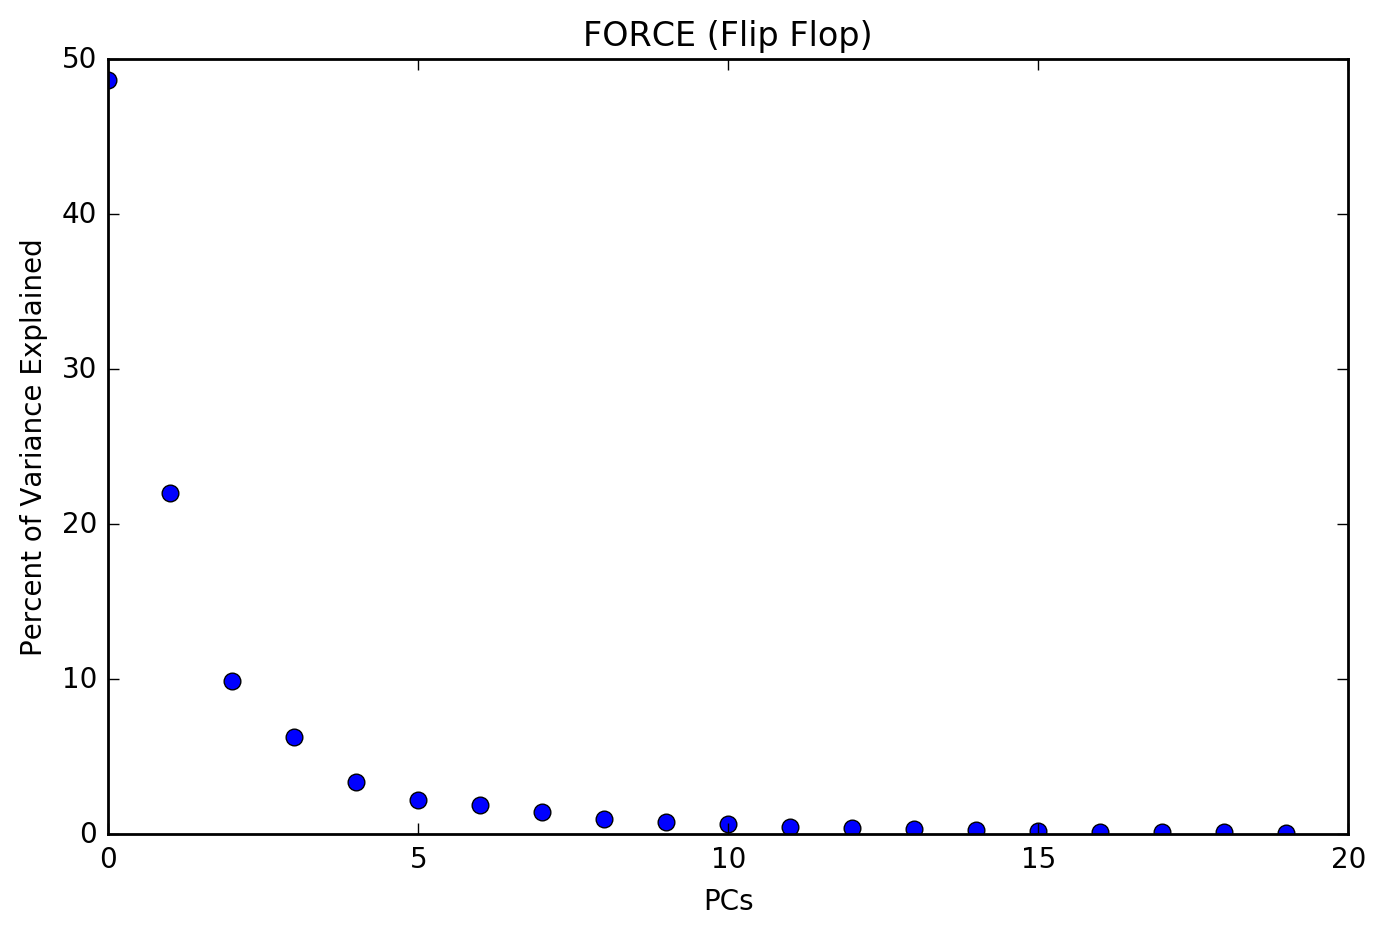

In [46]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [47]:
pca = PCA(n_components=3)
pca.fit(x)
pca_x = pca.transform(x).T

In [48]:
pca_x.shape

(3, 1002)

In [49]:
reload(plot)

<module 'jedi.utils.plot' from '/Users/simonhaxby/Code/Python/jedi/utils/plot.pyc'>

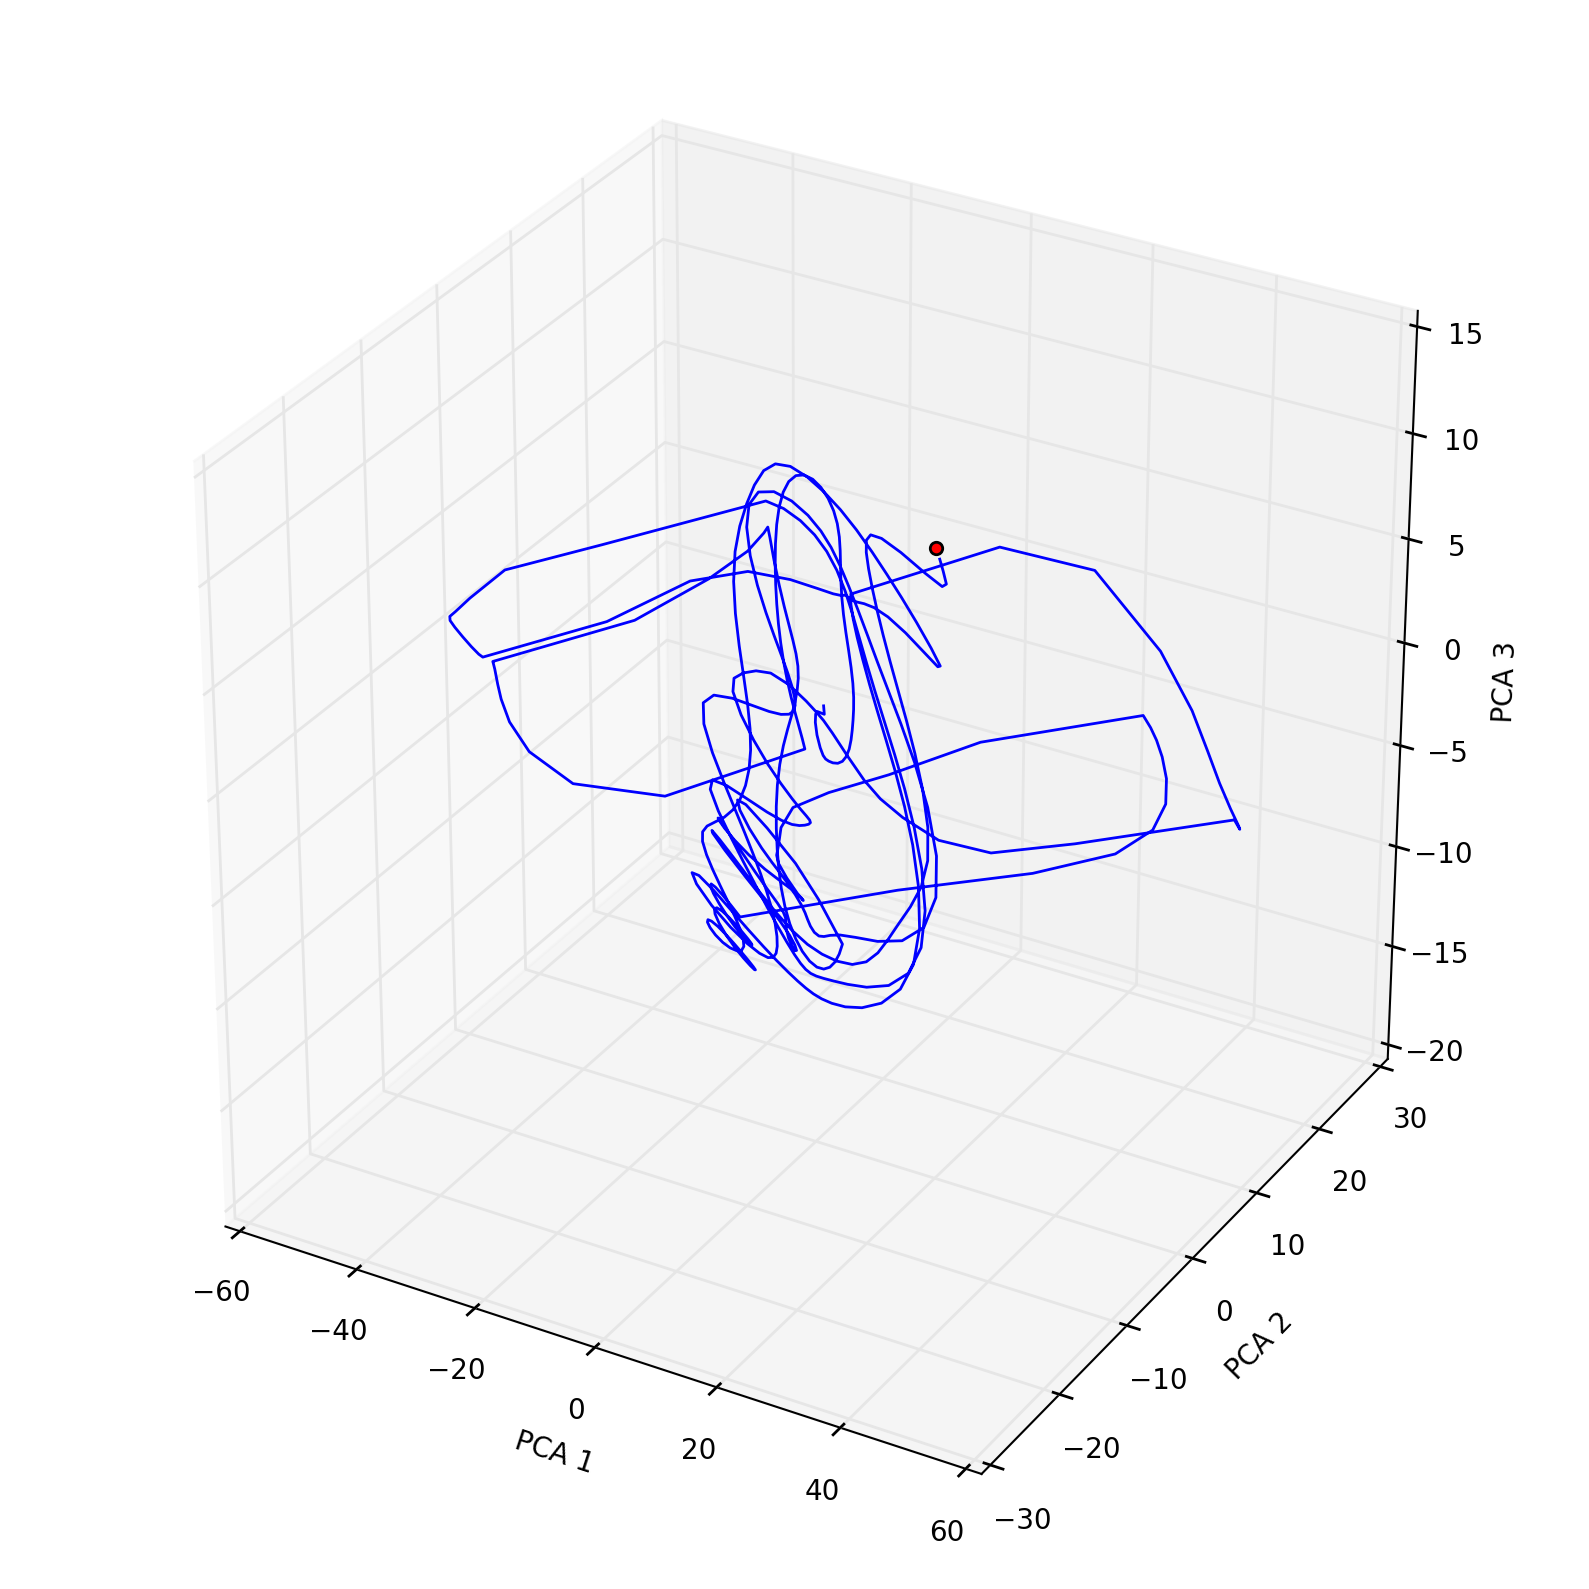

In [50]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_3dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));